In [ ]:
import networkx as nx     # Used to Implement Graphs in Python
import math
import sys
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("RFAnet.csv", header=None, names=["source", "target", "rating"])

**Exploring Our Dataset**

In [ ]:
df.shape

(104554, 3)

In [ ]:
df.head()

,source,target,rating
0,5988,5849,0.437
1,5989,9263,-0.237
2,5989,7930,0.167
3,5989,8172,0.242
4,5989,8609,0.211


In [ ]:
df.describe()

,source,target,rating
count,104554.000000,104554.000000,104554.000000
mean,3125.153834,3529.265643,0.235352
std,2479.682554,2615.536732,0.259216
min,0.000000,1.000000,-1.000000
25%,897.000000,1269.000000,0.070000
50%,2654.000000,3013.000000,0.212000
75%,5080.000000,5411.000000,0.385000
max,9658.000000,9657.000000,1.000000


In [ ]:
df.isnull().any()

source    False
target    False
rating    False
dtype: bool

**Preprocessing the Data**



1. Removing edges with absence of a Link (Weight = 0) 



In [ ]:
df = df[df["rating"]!=0]

2. Splitting the weight column into categorical data, of two classes +1 and -1 (Representing Positive and Negative Edges Respectively)

In [ ]:
df["rating"] = df["rating"].apply(lambda x:1 if x > 0 else -1)
df.head()

,source,target,rating
0,5988,5849,1
1,5989,9263,-1
2,5989,7930,1
3,5989,8172,1
4,5989,8609,1


3. Dropping (b,a) if (a,b) is an edge present in the data. Thus, ensuring that only unique pairs of edges are present in our data, to make an Undirected Graph.

In [ ]:
df.loc[pd.DataFrame(np.sort(df[['source','target']],1),index=df.index).drop_duplicates(keep='first').index]
df.head()

,source,target,rating
0,5988,5849,1
1,5989,9263,-1
2,5989,7930,1
3,5989,8172,1
4,5989,8609,1


Adding Edges and Creating our Graph (Using networkx) 

In [ ]:
G = nx.Graph()
for ind in df.index:
  G.add_edge(df['source'][ind], df['target'][ind], weight = df['rating'][ind])

In [ ]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 9654\nNumber of edges: 101886\nAverage degree:  21.1075'

Visualizing Our Graph

In [ ]:
#import matplotlib.pyplot as plt
#nx.draw(G)  
#plt.draw()

Ensure that the Graph is Connected

In [ ]:
nx.is_connected(G)

True

Storing the centrality, clustering coefficient and Node Degree value for every node in repective Dictionaries.

In [ ]:
centrality_dict = nx.algorithms.centrality.degree_centrality(G)
clustering_dict = nx.algorithms.cluster.clustering(G)
degree_dict = {}
for node in G.nodes():
  degree_dict[node] = G.degree(node)

In [ ]:
def centrality(node):
  return centrality_dict[node]

In [ ]:
def cluster_coeff(node):
  return clustering_dict[node]

Function to calculate **'Shortest Path Length'**

In [ ]:
def spl(node1, node2):
  w = G[node1][node2]["weight"]
  Flag=False
  try:
    G.remove_edge(node1,node2)
    nx.shortest_path_length(G, source=node1, target=node2)
    Flag = True
  except Exception as e:
    G.add_edge(node1,node2,weight = w)
    Flag = False
  ans = nx.shortest_path_length(G, source=node1, target=node2)
  if Flag:
    G.add_edge(node1,node2,weight=w)
  return ans

Getting the 75th Percentile Node Degree to check N High Degree Nodes.

In [ ]:
degrees = [G.degree(node) for node in G.nodes()] 

df_degrees = pd.DataFrame({'Degrees':degrees})

df_degrees.describe()

,Degrees
count,9654.000000
mean,21.107520
std,41.322578
min,1.000000
25%,1.000000
50%,4.000000
75%,22.000000
max,627.000000


In [ ]:
percentile65 = 15.00

Function to calculate **'N High Degree Nodes in a Path'**

In [ ]:
def n_high_degree(node1, node2):
  w = G[node1][node2]["weight"]
  flag = False
  try:
    G.remove_edge(node1,node2)
    nx.shortest_path(G, source=node1, target=node2)
    Flag = True
  except Exception as e:
    G.add_edge(node1,node2,weight=w)
    Flag = False
  n=0
  for ele in nx.shortest_path(G, source=node1, target=node2):
    if G.degree[ele] > percentile65:
      n+=1
  if Flag:
    G.add_edge(node1,node2,weight=w)
    
  return n

Function to calculate **'Propensity of a Node'**

In [ ]:
def propensity(node):
  List = [edge for edge in G.edges(node)]
  n = len(List)
  k=0
  for edge in List:
    if G[edge[0]][edge[1]]['weight']>0:
      k+=1
  if n == 0:
    return 0
  return float(k)/n

Function to calculate **'Ratio of Mutual Neighbours with Same Sign'**

In [ ]:
def r_mutual(node1,node2):
  k = 0
  n = 0
  for ele in nx.common_neighbors(G,node1,node2):
    if G[node1][ele]['weight']*G[node2][ele]['weight']>0:
      k+=1
    n+=1
  if n==0:
    return 0
  return float(k)/n

Function to calculate **'Ratio of Structurally Balanced Paths'**

In [ ]:
from itertools import islice
def k_shortest_paths(G, source, target, k):
    return list(
        islice(nx.shortest_simple_paths(G, source, target), k)
    )

def r_balanced(node1,node2):
  n=0
  k=0
  for path in k_shortest_paths(G, node1, node2, 10):
    n+=1
    neg=0
    for u,v in zip(path[0:],path[1:]):
      if G[u][v]['weight'] == -1:
        neg+=1
    if neg%2 == 0:
      k+=1
  return float(k)/n

**CREATING OUR FINAL TRAIN DATASET**

In [ ]:
column_names = ['node_1','node_2','node_centrality1','node_centrality2','cluster_coeff1','cluster_coeff2','propensity1','propensity2','shortest_path_length','n_high_degree','r_balanced','r_mutual','rating']

In [ ]:
dataset = pd.DataFrame(columns = column_names)

In [ ]:
from tqdm import tqdm

In [ ]:
L = len(G.edges())
for i, edge in zip(tqdm(range(L), ncols = 100, desc ="Progress"),G.edges()):
  dataset = dataset.append({'node_1':edge[0],
                  'node_2':edge[1],
                  'node_centrality1' : centrality_dict[edge[0]],
                  'node_centrality2' : centrality_dict[edge[1]],
                  'propensity1': propensity(edge[0]),
                  'propensity2': propensity(edge[1]), 
                  'cluster_coeff1' : clustering_dict[edge[0]],
                  'cluster_coeff2' : clustering_dict[edge[1]],
                  'shortest_path_length' : spl(edge[0],edge[1]),
                  'n_high_degree' : n_high_degree(edge[0],edge[1]),
                  'r_balanced': r_balanced(edge[0],edge[1]),
                  'r_mutual': r_mutual(edge[0],edge[1]),
                  'rating' : G[edge[0]][edge[1]]['weight']
                  }, ignore_index=True )

In [ ]:
dataset = pd.read_csv('FinalData.csv')

In [ ]:
dataset.head(8)

,node_1,node_2,node_centrality1,node_centrality2,cluster_coeff1,cluster_coeff2,propensity1,propensity2,shortest_path_length,n_high_degree,r_balanced,r_mutual,rating
0,5988.0,5849.0,0.001968,0.006319,0.134503,0.088525,1.0,0.967213,2.0,3.0,0.9,1.0,1.0
1,5988.0,5989.0,0.001968,0.009427,0.134503,0.105739,1.0,0.835165,3.0,4.0,0.7,0.0,1.0
2,5988.0,2685.0,0.001968,0.010981,0.134503,0.113747,1.0,0.858491,2.0,3.0,0.8,1.0,1.0
3,5988.0,4727.0,0.001968,0.030975,0.134503,0.072389,1.0,0.859532,2.0,3.0,1.0,1.0,1.0
4,5988.0,254.0,0.001968,0.061328,0.134503,0.059868,1.0,0.979730,2.0,3.0,1.0,1.0,1.0
5,5988.0,5107.0,0.001968,0.032943,0.134503,0.045156,1.0,0.830189,2.0,3.0,0.9,1.0,1.0
6,5988.0,107.0,0.001968,0.016161,0.134503,0.109512,1.0,0.891026,2.0,3.0,0.9,1.0,1.0
7,5988.0,5991.0,0.001968,0.003626,0.134503,0.163025,1.0,0.885714,2.0,3.0,0.6,1.0,1.0


In [ ]:
dataset.columns

Index(['node_1', 'node_2', 'node_centrality1', 'node_centrality2',
       'cluster_coeff1', 'cluster_coeff2', 'propensity1', 'propensity2',
       'shortest_path_length', 'n_high_degree', 'r_balanced', 'r_mutual',
       'rating'],
      dtype='object')

In [ ]:
dataset.shape

(101886, 13)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(dataset[column_names[2:12]])
dataset[column_names[2:12]] = min_max_scaler.transform(dataset[column_names[2:12]])

In [ ]:
dataset.head()

,node_1,node_2,node_centrality1,node_centrality2,cluster_coeff1,cluster_coeff2,propensity1,propensity2,shortest_path_length,n_high_degree,r_balanced,r_mutual,rating
0,5988.0,5849.0,0.028754,0.095847,0.134503,0.088525,1.0,0.967213,0.4,0.6,0.9,1.0,1.0
1,5988.0,5989.0,0.028754,0.143770,0.134503,0.105739,1.0,0.835165,0.6,0.8,0.7,0.0,1.0
2,5988.0,2685.0,0.028754,0.167732,0.134503,0.113747,1.0,0.858491,0.4,0.6,0.8,1.0,1.0
3,5988.0,4727.0,0.028754,0.476038,0.134503,0.072389,1.0,0.859532,0.4,0.6,1.0,1.0,1.0
4,5988.0,254.0,0.028754,0.944089,0.134503,0.059868,1.0,0.979730,0.4,0.6,1.0,1.0,1.0


In [ ]:
dataset[column_names]=dataset[column_names].astype('float')

In [ ]:
dataset.head()

,node_1,node_2,node_centrality1,node_centrality2,cluster_coeff1,cluster_coeff2,propensity1,propensity2,shortest_path_length,n_high_degree,r_balanced,r_mutual,rating
0,5988.0,5849.0,0.028754,0.095847,0.134503,0.088525,1.0,0.967213,0.4,0.6,0.9,1.0,1.0
1,5988.0,5989.0,0.028754,0.143770,0.134503,0.105739,1.0,0.835165,0.6,0.8,0.7,0.0,1.0
2,5988.0,2685.0,0.028754,0.167732,0.134503,0.113747,1.0,0.858491,0.4,0.6,0.8,1.0,1.0
3,5988.0,4727.0,0.028754,0.476038,0.134503,0.072389,1.0,0.859532,0.4,0.6,1.0,1.0,1.0
4,5988.0,254.0,0.028754,0.944089,0.134503,0.059868,1.0,0.979730,0.4,0.6,1.0,1.0,1.0


In [ ]:
dataset['rating'] = dataset['rating'].apply(lambda x: 0 if x == 1 else 1)

In [ ]:
print('Percentage of Negative Edges: {0}%'.format(round(100 * dataset['rating'].sum() / len(dataset['rating']), 2)))

Percentage of Negative Edges: 16.28%


In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Empirical distribution of Edge Weights')

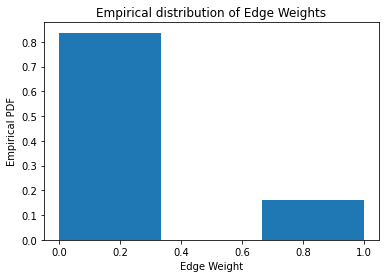

In [ ]:
plt.hist(dataset['rating'], bins=3, weights=np.ones(len(dataset['rating'])) / len(dataset['rating']))
plt.xlabel('Edge Weight')
plt.ylabel('Empirical PDF')
plt.title('Empirical distribution of Edge Weights')

In [ ]:
X_trainAB = data.drop(['node_1','node_2','rating'], axis = 1)
X_trainA = data[['shortest_path_length','n_high_degree','r_balanced','r_mutual']]
y_train = data['rating']

X_testAB = test_data.drop(['node_1','node_2','rating'], axis = 1)
X_testA = test_data[['shortest_path_length','n_high_degree','r_balanced','r_mutual']]
y_test = test_data['rating']

In [ ]:
data, test_data = train_test_split(dataset, test_size=0.3)
print('Train-valid data length: {0}'.format(len(data)))
print('Test data length: {0}'.format(len(test_data)))

Train-valid data length: 71320
Test data length: 30566


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
modelA = GaussianNB()
modelAB = GaussianNB()

In [ ]:
modelA.fit(X_trainA, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
modelAB.fit(X_trainAB, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
modelA.score(X_testA, y_test)

0.8159719950271543

In [ ]:
modelAB.score(X_testAB, y_test)

0.8505529019171628

In [259]:
y_pred = np.array([])

In [260]:
for cols in test_data.values:
  if degree_dict[cols[0]]<10 and degree_dict[cols[1]]<10:
    y_pred = np.append(y_pred, modelA.predict(cols[8:12].reshape(1, -1)))
  else:
    y_pred = np.append(y_pred, modelAB.predict(cols[2:12].reshape(1, -1)))

In [262]:
accuracy_score(y_test,y_pred)

0.8704547536478441


In [ ]:
def Predict_Edge(node1,node2):

  cols= np.array([node1,
        node2,
        centrality_dict[node1],
        centrality_dict[node2],
        propensity(node1),
        propensity(node2), 
        clustering_dict[node1],
        clustering_dict[node2],
        spl(node1,node2),
        n_high_degree(node1,node2),
        r_balanced(node1,node2),
        r_mutual(node1,node2),
        G[node1][node2]['weight']])
  
  #print(cols.shape)
  cols = min_max_scaler.transform(cols[2:12].reshape(1, -1))
  #print(cols.shape)
  if degree_dict[node1]<10 and degree_dict[node2]<10:
    if modelA.predict(cols[0][6:10].reshape(1, -1)) == 0:
      return 0
    else:
      return 1
  else:
    if modelAB.predict(cols[0].reshape(1, -1)) == 0:
      return 0
    else:
      return 1

In [ ]:
for cols in test_data.values:
  y_pred = np.append(y_pred, Predict_Edge(cols[0],cols[1]))

In [256]:
dataset[['node_centrality2',	'cluster_coeff2',	'propensity2',	'shortest_path_length', 'n_high_degree',	'r_balanced',	'r_mutual',	'rating']].describe(
)

,node_centrality2,cluster_coeff2,propensity2,shortest_path_length,n_high_degree,r_balanced,r_mutual,rating
count,101886.000000,101886.000000,101886.000000,101886.00000,101886.000000,101886.000000,101886.000000,101886.000000
mean,0.128161,0.130538,0.831920,0.41472,0.561117,0.778873,0.687677,0.162760
std,0.142084,0.101821,0.183326,0.07378,0.107101,0.215226,0.353767,0.369149
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.033546,0.080882,0.767606,0.40000,0.600000,0.700000,0.500000,0.000000
50%,0.089457,0.114967,0.888889,0.40000,0.600000,0.800000,0.818182,0.000000
75%,0.169329,0.157505,0.958333,0.40000,0.600000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
